<a href="https://colab.research.google.com/github/sjangeli/Thinkful-Data-Science-Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Chicago Arrest Predictor: Public safety is a concern for all large urban areas. This projects seeks to gain insight into criminal and policing behavior and attempt to generate probabilities and predictions of whether a particular criminal report will result in an arrest. Arrests are an important consideration because of the impact they have on the individual's future life prospects and on public resources as arrests trigger a domino effect of city resources.

Use Cases: 

1. This tool provides Chicago police dispatchers with real-time predictions on whether an arrest will occur based on the initial police report. Having real-time predictions will enable dispatchers to make more informed decisions about how to use finite police resources in the most effective and efficient manner. 
2. The analysis will provide police and city administrators with insight into the crime profile of Chicago through visualizations and mapping.
3. Enable community leaders to scrutinize the equity of past and current police behavior and outcomes.

# Project Setup

In [1]:
# Install Java, Spark, Findspark and PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

!pip install -q findspark
!pip install pyspark

# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 217.8MB 30kB/s 
     |████████████████████████████████| 204kB 55.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=7a27a6af3b006296ac0d8c0cab39246cb6dc166acc3f62a1d934f2825cbf2b92
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp

import requests
import json

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [3]:
# Data Processing and Analysis Tools imports

import datetime
from pyspark.sql.functions import when, count, isnull, col, month, dayofweek, hour

# Pandas and EDA tool imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Unsupervised learning tools
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics

# Pipeline tools
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

# Classifiers and tools
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Set up and start a Spark Session.

APP_NAME = "Chicago Crime Data"
SPARK_URL = "local[*]"

spark = (SparkSession
         .builder
         .appName(APP_NAME)
         .config('spark.executor.memory', '2G')
         .config('spark.driver.memory', '12G')
         .config('spark.driver.maxResultSize', '2G')
         .master(SPARK_URL)
         .getOrCreate())

# Data Extraction

The City of Chicago Data Portal is an open data platform that makes use of a SODA API. The Crime dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and will be analyzed in this project with a combination of Spark and Pandas tools.

In [0]:
# Set parameters for the Chicago Data Portal API query

main_api ='https://data.cityofchicago.org/resource/crimes.json'
limit = 50000
offset = 0
path = '/content/gdrive/My Drive/Colab Datasets/final_project_files/'
filename = 'data_'
filenum = 1

In [0]:
# Call the City Data Portal for crime data and store results in files on gdrive. Three million results should be enough data for my purpose.
while offset < 3000000:
  response = requests.get(main_api + '?' + '$limit=' + str(limit) + '&' + '$offset=' + str(offset))
  data = response.json()
  with open(path + filename + str(filenum) + '.json', 'w') as f: 
    json.dump(data, f)
  offset += limit
  filenum += 1

In [7]:
# Read all the json data files into a Spark Dataframe.

df = spark.read.json(path + '*.json')
df.show()

+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+------+----+--------------------+-----------+--------------+--------------------+--------------------+--------+--------+--------+-------+----+------------+--------------------+--------------------+-------------+------------------+--------------------+----+------------+------------+----+
|:@computed_region_43wa_7qmu|:@computed_region_6mkv_f3dw|:@computed_region_awaf_s7ux|:@computed_region_bdys_3d7i|:@computed_region_d3ds_rm58|:@computed_region_d9mm_jgwp|:@computed_region_rpca_8um6|:@computed_region_vrxf_vc4k|arrest|beat|               block|case_number|community_area|                date|         description|district|domestic|fbi_code|     id|iucr|    latitude|            location|location_description|    longitude|      primary_type|          updated_on|ward|x_coor

In [8]:
# Check to ensure I have the number of observations that I sought out to collect.

df.count()

3000001

# Data Cleaning

In [0]:
# Drop unneccessary columns. 

columns_to_drop = ([':@computed_region_43wa_7qmu', ':@computed_region_6mkv_f3dw', ':@computed_region_awaf_s7ux', 
                    ':@computed_region_bdys_3d7i', ':@computed_region_d3ds_rm58', ':@computed_region_d9mm_jgwp', 
                    ':@computed_region_rpca_8um6', ':@computed_region_vrxf_vc4k', 'block', 'case_number', 'id',
                    'location', 'updated_on', 'x_coordinate', 'y_coordinate'])

df = df.drop(*columns_to_drop)

In [10]:
# Check to see columns are correct. 

df.columns

['arrest',
 'beat',
 'community_area',
 'date',
 'description',
 'district',
 'domestic',
 'fbi_code',
 'iucr',
 'latitude',
 'location_description',
 'longitude',
 'primary_type',
 'ward',
 'year']

In [11]:
# Check that the schema was inferred correctly. 

df.printSchema()

root
 |-- arrest: boolean (nullable = true)
 |-- beat: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)



In [0]:
# Re-cast a few incorrect data types.
df = df.withColumn("latitude", df['latitude'].cast('float'))
df = df.withColumn("longitude", df['longitude'].cast('float'))
df = df.withColumn("date", to_timestamp("date"))
# df.show()

In [13]:
# Check that the schema is now correct. 

df.printSchema()

root
 |-- arrest: boolean (nullable = true)
 |-- beat: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- location_description: string (nullable = true)
 |-- longitude: float (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)



In [14]:
# Find the prevalence of Null values

all_cols = df.columns

df.select([count(when(isnull(c), c)).alias(c) for c in all_cols]).show()

+------+----+--------------+----+-----------+--------+--------+--------+----+--------+--------------------+---------+------------+----+----+
|arrest|beat|community_area|date|description|district|domestic|fbi_code|iucr|latitude|location_description|longitude|primary_type|ward|year|
+------+----+--------------+----+-----------+--------+--------+--------+----+--------+--------------------+---------+------------+----+----+
|     0|   0|           393|   0|          0|       1|       0|       0|   0|   22427|                6394|    22427|           0|  62|   0|
+------+----+--------------+----+-----------+--------+--------+--------+----+--------+--------------------+---------+------------+----+----+



In [15]:
# Since there are so few null values I feel confident that dropping them won't impact the integrity of the model.

df = df.na.drop()
df.count()

2972864

In [0]:
# Create some time-based features.

df = df.withColumn("month", month("date"))
df = df.withColumn("hour", hour("date"))
df = df.withColumn("dayofweek", dayofweek("date"))

In [17]:
# Get some basic numbers on the dataset using Spark:

print("Number of unique beats in dataset: {}".format(df.select('beat').distinct().count()))
print("Number of unique community areas in dataset: {}".format(df.select('community_area').distinct().count()))
print("Number of unique districts in dataset: {}".format(df.select('district').distinct().count()))
print("Number of unique fbi codes in dataset: {}".format(df.select('fbi_code').distinct().count()))
print("Number of unique illinois crime codes in dataset: {}".format(df.select('iucr').distinct().count()))
print("Number of unique location descriptions in dataset: {}".format(df.select('location_description').distinct().count()))
print("Number of unique types of violations in dataset: {}".format(df.select('primary_type').distinct().count()))
print("Number of unique wards in dataset: {}".format(df.select('ward').distinct().count()))
print("Number of unique hours in dataset: {}".format(df.select('hour').distinct().count()))
print("Number of unique days of the week in dataset: {}".format(df.select('dayofweek').distinct().count()))
print("Number of unique months in dataset: {}".format(df.select('month').distinct().count()))

Number of unique beats in dataset: 303
Number of unique community areas in dataset: 78
Number of unique districts in dataset: 23
Number of unique fbi codes in dataset: 26
Number of unique illinois crime codes in dataset: 376
Number of unique location descriptions in dataset: 195
Number of unique types of violations in dataset: 34
Number of unique wards in dataset: 50
Number of unique hours in dataset: 24
Number of unique days of the week in dataset: 7
Number of unique months in dataset: 12


# Exploratory Data Analysis

Now that I have a clean Spark dataframe I'm going to turn to pandas to do some exploratory data analysis on a subsample of the Spark dataframe.

In [0]:
# Select a subsample of data to use in pandas

s_df = df.select('*').sample(withReplacement=False, fraction=0.05, seed=13)
s_df_pandas = s_df.toPandas() 

In [19]:
# Check to see how many observations I have in my pandas dataframe.

len(s_df_pandas)

148832

In [20]:
# Check to see that everything looks correct in pandas.

s_df_pandas.head()

,arrest,beat,community_area,date,description,district,domestic,fbi_code,iucr,latitude,location_description,longitude,primary_type,ward,year,month,hour,dayofweek
0,True,0632,44,2010-03-26 22:21:00,POSS: CANNABIS 30GMS OR LESS,006,False,18,1811,41.743031,STREET,-87.605011,NARCOTICS,6,2010,3,22,6
1,False,2234,75,2010-03-26 22:00:00,ILLEGAL USE CASH CARD,022,True,11,1152,41.686337,RESIDENCE,-87.650711,DECEPTIVE PRACTICE,34,2010,3,22,6
2,False,1233,31,2010-03-26 22:00:00,TO VEHICLE,012,False,14,1320,41.856201,VEHICLE NON-COMMERCIAL,-87.643112,CRIMINAL DAMAGE,25,2010,3,22,6
3,False,0823,66,2010-03-26 21:12:00,AGGRAVATED: HANDGUN,008,False,04B,041A,41.776821,SIDEWALK,-87.694557,BATTERY,15,2010,3,21,6
4,False,1011,29,2010-03-26 20:51:51,UNLAWFUL POSS OF HANDGUN,010,False,15,143A,41.863461,APARTMENT,-87.726318,WEAPONS VIOLATION,24,2010,3,20,6


In [0]:
# Create additional time of day indicator variables:

s_df_pandas['early_morning'] = ((s_df_pandas.hour >= 0) & (s_df_pandas.hour < 6)).astype(int)
s_df_pandas['morning'] = ((s_df_pandas.hour >= 6) & (s_df_pandas.hour < 12)).astype(int)
s_df_pandas['afternoon'] = ((s_df_pandas.hour >= 12) & (s_df_pandas.hour < 18)).astype(int)
s_df_pandas['evening'] = ((s_df_pandas.hour >= 18) & (s_df_pandas.hour < 24)).astype(int)

In [0]:
# Create additional day of week indicator variables:

s_df_pandas['monday'] = (s_df_pandas.dayofweek == 0).astype(int)
s_df_pandas['tuesday'] = (s_df_pandas.dayofweek == 1).astype(int)
s_df_pandas['wednesday'] = (s_df_pandas.dayofweek == 2).astype(int)
s_df_pandas['thursday'] = (s_df_pandas.dayofweek == 3).astype(int)
s_df_pandas['friday'] = (s_df_pandas.dayofweek == 4).astype(int)
s_df_pandas['saturday'] = (s_df_pandas.dayofweek == 5).astype(int)
s_df_pandas['sunday'] = (s_df_pandas.dayofweek == 6).astype(int)

# Create a weekend indicator:

s_df_pandas['weekend'] = (s_df_pandas.dayofweek >= 4).astype(int)

In [0]:
# Create time of year indicator variables

s_df_pandas['winter'] = ((s_df_pandas.month == 12) & (s_df_pandas.month <= 2)).astype(int)
s_df_pandas['spring'] = ((s_df_pandas.month >= 3) & (s_df_pandas.month <= 5)).astype(int)
s_df_pandas['summer'] = ((s_df_pandas.month >= 6) & (s_df_pandas.month <= 8)).astype(int)
s_df_pandas['fall'] = ((s_df_pandas.month >= 9) & (s_df_pandas.month <= 11)).astype(int)

In [24]:
# Check that my variables are correct.

s_df_pandas.head()

,arrest,beat,community_area,date,description,district,domestic,fbi_code,iucr,latitude,location_description,longitude,primary_type,ward,year,month,hour,dayofweek,early_morning,morning,afternoon,evening,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekend,winter,spring,summer,fall
0,True,0632,44,2010-03-26 22:21:00,POSS: CANNABIS 30GMS OR LESS,006,False,18,1811,41.743031,STREET,-87.605011,NARCOTICS,6,2010,3,22,6,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0
1,False,2234,75,2010-03-26 22:00:00,ILLEGAL USE CASH CARD,022,True,11,1152,41.686337,RESIDENCE,-87.650711,DECEPTIVE PRACTICE,34,2010,3,22,6,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0
2,False,1233,31,2010-03-26 22:00:00,TO VEHICLE,012,False,14,1320,41.856201,VEHICLE NON-COMMERCIAL,-87.643112,CRIMINAL DAMAGE,25,2010,3,22,6,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0
3,False,0823,66,2010-03-26 21:12:00,AGGRAVATED: HANDGUN,008,False,04B,041A,41.776821,SIDEWALK,-87.694557,BATTERY,15,2010,3,21,6,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0
4,False,1011,29,2010-03-26 20:51:51,UNLAWFUL POSS OF HANDGUN,010,False,15,143A,41.863461,APARTMENT,-87.726318,WEAPONS VIOLATION,24,2010,3,20,6,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0


In [25]:
# Select columns that I want to do some EDA on using plots and see how many unique values I have in the subsample. Compare to what is present in the 
# full Spark dataset.

cols = ['domestic', 'beat', 'description', 'community_area', 'district', 'fbi_code', 'iucr', 'location_description', 'primary_type', 'ward', 'hour', 'dayofweek', 'month', 'weekend']

for col in cols:
  print("Number of unique {} in dataset: {}".format(col, s_df_pandas[col].nunique()))

Number of unique domestic in dataset: 2
Number of unique beat in dataset: 302
Number of unique description in dataset: 365
Number of unique community_area in dataset: 77
Number of unique district in dataset: 23
Number of unique fbi_code in dataset: 26
Number of unique iucr in dataset: 322
Number of unique location_description in dataset: 146
Number of unique primary_type in dataset: 33
Number of unique ward in dataset: 50
Number of unique hour in dataset: 24
Number of unique dayofweek in dataset: 7
Number of unique month in dataset: 12
Number of unique weekend in dataset: 2


## Arrest Rate Plots

The first area of exploration is in whether there is any variability in the rate of arrests depending on the factors contained in the police report including when, where, and what type of crime is being reported. For a link to the FBI Codes referenced throughout the rest of this project: http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html#N06

In [26]:
# Get a baseline average arrest rate

print("Average Arrest Rate: {}".format(len(s_df_pandas[s_df_pandas['arrest'] == 1])/len(s_df_pandas)))

Average Arrest Rate: 0.24649940872930554


In [0]:
# Create a function that determines the percentage of arrests that occur out of all reports for a given variable.

def percent_arrest(col):
  cat_vals = s_df_pandas[col].unique() 
  results = {}
  for val in cat_vals:
    if len(s_df_pandas[(s_df_pandas[col] == val)]) != 0:
      percent = round(100 * len(s_df_pandas[(s_df_pandas[col] == val) & 
        (s_df_pandas.arrest == True)])/len(s_df_pandas[(s_df_pandas[col] == val)]), 2)
      # print("Percentage of reports that lead to arrests in {} {} is: {}".format(
      #   col, val, percent))
      results[val] = percent
    else:
      continue
  return results

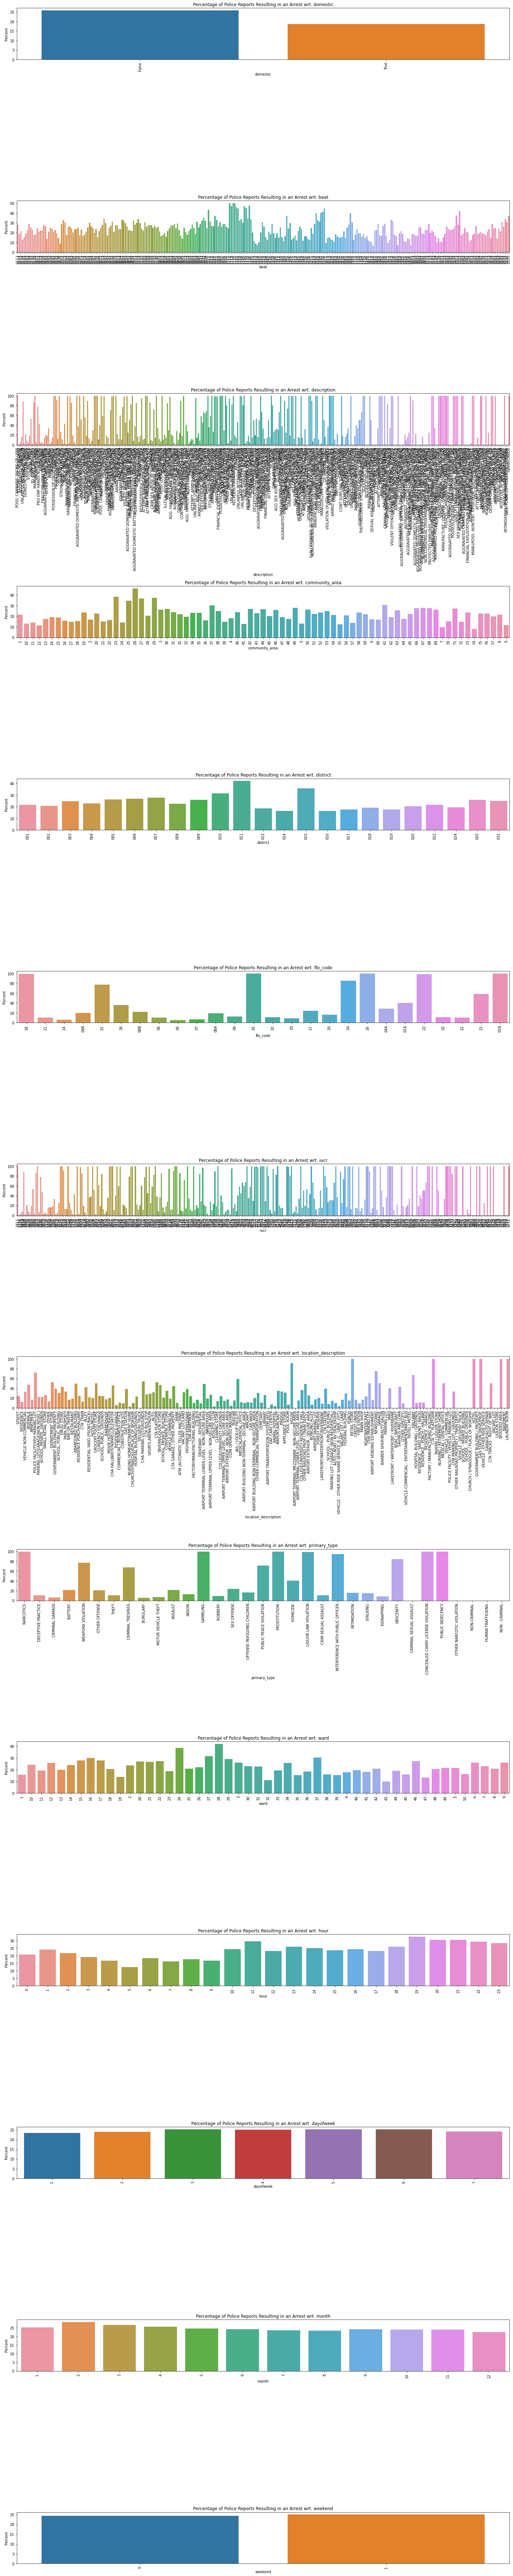

In [28]:
# Create plots of each feature and its percentage of arrests to see if there is any sizeable variance.

plt.figure(figsize=(20,100))
index = 1

for col in cols:
  plt.subplot(len(cols), 1, index)
  sns.barplot(x=list(percent_arrest(col).keys()), y=list(percent_arrest(col).values()))
  plt.title("Percentage of Police Reports Resulting in an Arrest wrt. {}".format(col))
  plt.xlabel(col)
  plt.ylabel('Percent')
  plt.xticks(rotation='vertical')
  index += 1

plt.tight_layout()
plt.show()


As the above plots show there is significant variability in the arrest rate depending on when, where, and what type of crime is being reported. Next I'll look to see whether the arrest rate fluctuates according to which district in the city the crime is reported to have occurred. A map of Chicago district boundaries is shown below.

![alt text](https://drive.google.com/uc?id=1QOlfCNJTNv1zoKlIfFlQZcvpu8-MC_uy)

In [0]:
# Create a function that will help create a table of arrest rate by district.
def percent_arrest_by_district_and_crime(dis, crime):
  if len(s_df_pandas[(s_df_pandas['district'] == dis) & (s_df_pandas['fbi_code'] == crime)]) != 0:
    result = s_df_pandas[(s_df_pandas['district'] == dis) & (s_df_pandas['fbi_code'] == crime)]
    num_arrest = len(result[result['arrest'] == True])
    per = 100*num_arrest/len(result)
  else:
    per = 0
  return int(per)

In [0]:
# Create an array of arrest rates for each district and crime.

districts = [i for i in s_df_pandas['district'].unique()]
crimes = [i for i in s_df_pandas['fbi_code'].unique()]

table = [[percent_arrest_by_district_and_crime(district, crime) for district in districts] for crime in crimes if percent_arrest_by_district_and_crime]


In [31]:
# Turn the array into a dataframe.

table_df = pd.DataFrame(table, index=crimes, columns=districts)
table_df.head()

,006,022,012,008,010,003,025,024,017,009,002,004,020,014,007,011,005,015,001,019,016,018,031
18,99,99,99,99,99,99,100,100,100,99,99,100,99,100,99,99,99,99,99,100,99,97,0
11,13,4,5,4,12,10,6,5,5,18,5,4,4,6,16,34,6,6,14,8,6,13,100
14,6,6,4,6,7,7,4,5,4,7,4,5,10,6,7,6,5,5,9,6,4,8,0
04B,23,18,19,21,15,22,26,27,19,21,22,16,43,19,16,14,14,20,27,21,29,27,0
15,86,88,76,78,75,83,74,60,62,67,72,79,33,76,81,77,76,63,85,86,80,95,0


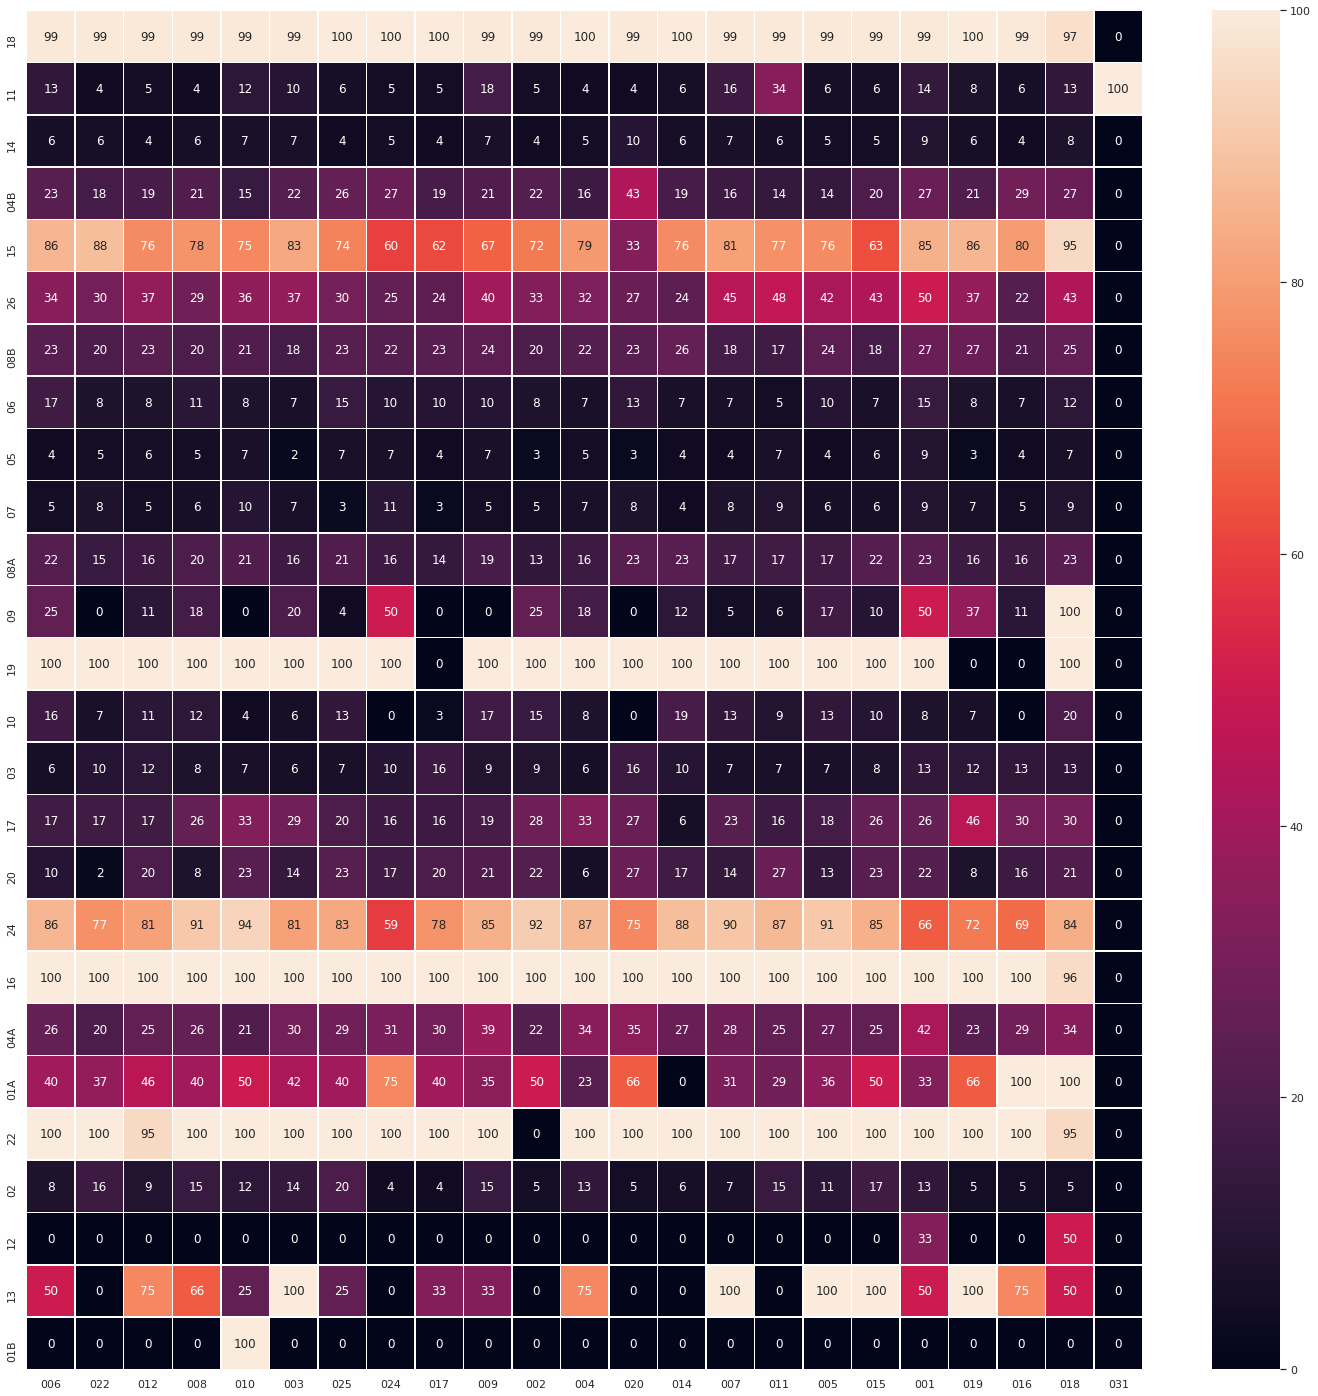

In [32]:
# Heatmap of arrest rate
sns.set()
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(table_df, annot=True, linewidths=.5, ax=ax, fmt='d')
plt.show()

### Arrest Rate Summary

The average arrest rate in Chicago over the past 10 years is 24.7%. From the above series of graphs and tables we can see that this rate significantly varies from its average depending on when, where, and what type of crime was reported. We see particularly elevated rates of arrest in districts 11, 15, and 3 and tremendous differences in the rate according to the fbi coded type of crime particularly with codes 18, 15, 24, 16, 19, 22, 13 and 01B having very high rates of arrest. Lastly we also see the rate fluctuate according to time of day with the highest rates of arrest occuring from 7pm to 12pm.

## Number Police Reports Resulting in Arrests

Percentages only tell part of the story. My next area of interest is in the raw amount of reports that result in arrest. This will give a clearer picture of the most prevalent factors that most often lead to arrests.

In [0]:
# Create a function that determines the number of arrests that occur for a given variable.

def num_arrest(col):
  cat_vals = s_df_pandas[col].unique() 
  results = {}
  for val in cat_vals:
    if len(s_df_pandas[(s_df_pandas[col] == val)]) != 0:
      num = len(s_df_pandas[(s_df_pandas[col] == val) & (s_df_pandas.arrest == True)])
      results[val] = num
    else:
      continue
  return results

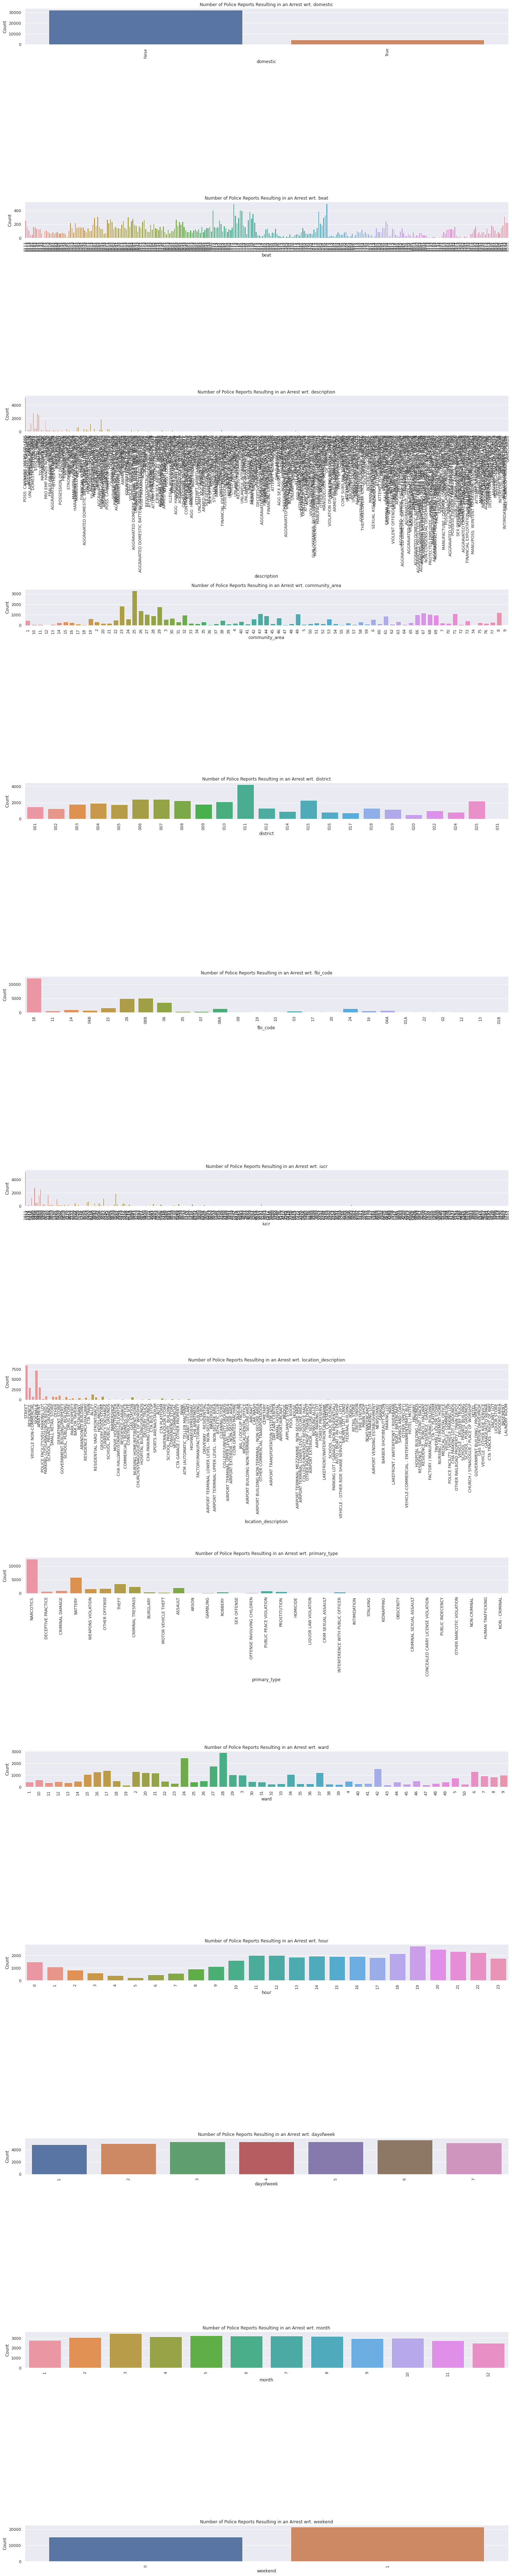

In [34]:
# Create plots of each feature and its number of arrests to see if there is any sizeable variance.

plt.figure(figsize=(20,100))
index = 1

for col in cols:
  plt.subplot(len(cols), 1, index)
  sns.barplot(x=list(num_arrest(col).keys()), y=list(num_arrest(col).values()))
  plt.title("Number of Police Reports Resulting in an Arrest wrt. {}".format(col))
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.xticks(rotation='vertical')
  index += 1

plt.tight_layout()
plt.show()

In [0]:
# Create a function that will help create a table of arrest rate by district.
def num_arrest_by_district_and_crime(dis, crime):
    result = s_df_pandas[(s_df_pandas['district'] == dis) & (s_df_pandas['fbi_code'] == crime)]
    num_arrest = len(result[result['arrest'] == True])
    return num_arrest

In [0]:
# Create an array of number of arrests for each district and crime.

districts = [i for i in s_df_pandas['district'].unique()]
crimes = [i for i in s_df_pandas['fbi_code'].unique()]

table = [[num_arrest_by_district_and_crime(district, crime) for district in districts] for crime in crimes if percent_arrest_by_district_and_crime]


In [37]:
# Turn the array into a dataframe.

table_df = pd.DataFrame(table, index=crimes, columns=districts)
table_df.head()

,006,022,012,008,010,003,025,024,017,009,002,004,020,014,007,011,005,015,001,019,016,018,031
18,690,311,298,656,940,620,691,203,189,570,361,535,107,202,828,2535,499,1273,111,251,180,123,0
11,45,11,18,19,18,23,18,11,12,45,15,11,8,17,33,92,12,10,103,47,21,108,1
14,60,33,38,81,53,55,42,30,28,67,34,61,31,38,71,51,45,35,34,45,27,39,0
04B,67,20,29,45,40,67,55,20,16,47,41,45,17,18,58,53,33,44,19,19,17,22,0
15,175,77,35,123,118,98,106,26,18,82,47,136,3,26,192,163,130,71,24,13,21,23,0


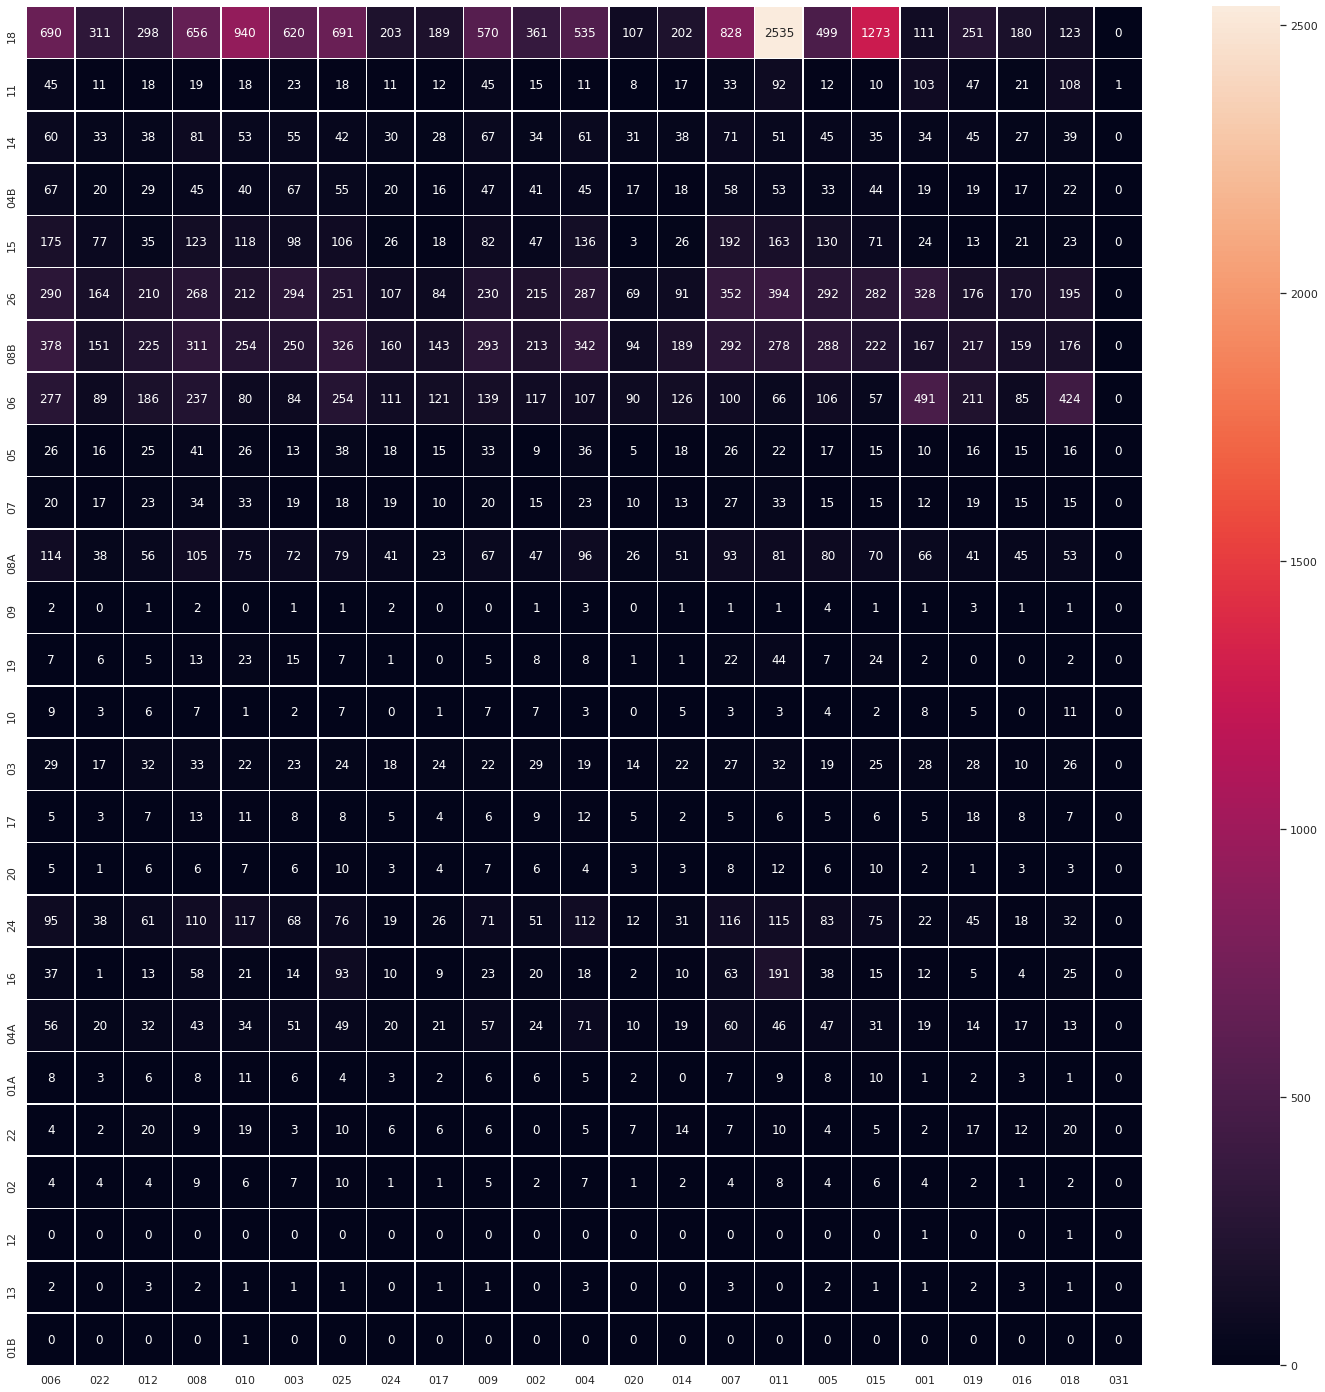

In [38]:
# Heatmap of arrests

sns.set()
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(table_df, annot=True, linewidths=.5, ax=ax, fmt='d')
plt.show()

### Police Reports Resulting in an Arrest Summary

We can see a high degree of variance in the number of arrests according to geographic values, type of crime committed, time of day and whether or not it is the weekend. The heatmap in particular shows that Narcotics arrests (FBI Code = 18) are heavily concentrated in Districts 11, 15, and 10. 

## Mapping Data

Spatial data can be easier to visualize using a map. I decided to illustrate the amount of reports and the rate of arrests for each district over the past 10 years to demonstrate potential uses of mapping this type of data.

In [0]:
plot_df = df.select("arrest", "district", "latitude", "longitude", "year")
plot_df = plot_df.withColumn("arrest", plot_df['arrest'].cast('int')) # turn boolean into numerical
plot_df = plot_df.join(plot_df.groupby('district').agg({'latitude': 'mean'}), on='district', how='left')
plot_df = plot_df.join(plot_df.groupby('district').agg({'longitude': 'mean'}), on='district', how='left')

In [0]:
a_df = plot_df.groupby('district', 'year').agg({'arrest': 'count'})
b_df = plot_df.groupby('district', 'year').agg({'arrest': 'sum'})
c_df = a_df.join(b_df, on=['district','year'], how='inner')
d_df = c_df.join(plot_df.select("district", "avg(latitude)", "avg(longitude)").distinct(), on='district', how='left')

In [0]:
import pyspark.sql.functions as F
d_df = d_df.withColumn("percent(arrest)", (F.col("sum(arrest)") / F.col("count(arrest)")))

In [42]:
d_df_pd = d_df.toPandas()
d_df_pd.head()

,district,year,count(arrest),sum(arrest),avg(latitude),avg(longitude),percent(arrest)
0,009,2015,12409,3309,41.81576,-87.665037,0.266661
1,009,2018,10867,2111,41.81576,-87.665037,0.194258
2,009,2017,11593,2411,41.81576,-87.665037,0.207970
3,009,2014,13465,3749,41.81576,-87.665037,0.278426
4,009,2012,16782,4560,41.81576,-87.665037,0.271720


In [43]:
drp_cols = d_df_pd.columns

d_df_pd['District'] = d_df_pd['district']
d_df_pd['Year'] = d_df_pd['year']
d_df_pd['Number of Police Reports'] = d_df_pd['count(arrest)']
d_df_pd['Number of Arrests'] = d_df_pd['sum(arrest)']
d_df_pd['Latitude'] = d_df_pd['avg(latitude)']
d_df_pd['Longitude'] = d_df_pd['avg(longitude)']
d_df_pd['Arrest Rate'] = d_df_pd['percent(arrest)']
d_df_pd = d_df_pd.drop(drp_cols, axis=1)
d_df_pd = d_df_pd.sort_values(by=["Year", "District"])
d_df_pd.head()


,District,Year,Number of Police Reports,Number of Arrests,Latitude,Longitude,Arrest Rate
183,001,2010,11385,2619,41.874044,-87.628956,0.230040
250,002,2010,14631,3617,41.809251,-87.611879,0.247215
119,003,2010,17987,4878,41.771057,-87.596462,0.271196
209,004,2010,19460,4372,41.734044,-87.563962,0.224666
128,005,2010,14963,3865,41.687525,-87.622537,0.258304


In [44]:
fig = px.scatter_geo(d_df_pd, lat='Latitude', lon='Longitude', color="Arrest Rate",
                     hover_name="District", size="Number of Police Reports", center={'lat':41.85, 'lon':-87.6}, 
                     title='Animated Plot of Percent of Reported Crimes Resulting in an Arrest by Chicago Police District (2010-2020)',
                     animation_frame="Year", scope='usa', range_color=[0.0,0.5])
fig.update_layout(
        geo = dict(landcolor = 'rgb(217, 217, 217)', lakecolor = 'rgb(235, 244, 250)'
        )
    )
fig.show()

## Clustering

In this section I investigate whether there are any obvious clusters within the data. Perhaps certain crimes are more likely to take place in certain places and at certain times than at others. In this section I utilize K-Means and GMM because Agglomerative/Hierarchical methods and DBSCAN are  too time expensive to run.

In [45]:
# Select a subsample of columns to use in clustering. Here I'm thinking of using variables that answer the What, When, and Where questions.

cols_unsup = ['arrest', 'district', 'fbi_code', 'morning', 'afternoon', 'evening', 'weekend', 'spring', 'summer', 'fall']

unsup_df = s_df_pandas[cols_unsup]
unsup_df.head()


,arrest,district,fbi_code,morning,afternoon,evening,weekend,spring,summer,fall
0,True,006,18,0,0,1,1,1,0,0
1,False,022,11,0,0,1,1,1,0,0
2,False,012,14,0,0,1,1,1,0,0
3,False,008,04B,0,0,1,1,1,0,0
4,False,010,15,0,0,1,1,1,0,0


In [46]:
# Get dummies on the dataframe since all variables are categorical. Check the shape for use in comparing after dropping correlated features. 

unsup_df_dm = pd.get_dummies(unsup_df, drop_first=True)
unsup_df_dm.arrest = unsup_df_dm.arrest.astype(int)
unsup_df_dm.shape

(148832, 55)

In [47]:
# Check to ensure get_dummies worked correctly. 

unsup_df_dm.head()

,arrest,morning,afternoon,evening,weekend,spring,summer,fall,district_002,district_003,district_004,district_005,district_006,district_007,district_008,district_009,district_010,district_011,district_012,district_014,district_015,district_016,district_017,district_018,district_019,district_020,district_022,district_024,district_025,district_031,fbi_code_01B,fbi_code_02,fbi_code_03,fbi_code_04A,fbi_code_04B,fbi_code_05,fbi_code_06,fbi_code_07,fbi_code_08A,fbi_code_08B,fbi_code_09,fbi_code_10,fbi_code_11,fbi_code_12,fbi_code_13,fbi_code_14,fbi_code_15,fbi_code_16,fbi_code_17,fbi_code_18,fbi_code_19,fbi_code_20,fbi_code_22,fbi_code_24,fbi_code_26
0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
# Drop correlated features:
unsup_features_df = unsup_df_dm.drop(labels='arrest', axis=1)

features_corrmat = unsup_features_df.corr().abs()

# Select upper triangle of correlation matrix
upper = features_corrmat.where(np.triu(np.ones(features_corrmat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features from the full unsupervised dataframe, including arrests.
unsup_df_dm = unsup_df_dm.drop(unsup_df_dm[to_drop], axis=1)

In [49]:
# Check the shape. 

unsup_df_dm.shape

(148832, 55)

### K-Means Elbow Method

In [0]:
# Using K-Means as one of our clustering techniques as agglomerative techniques will take too much time for the amount of observations in this
# small subsample.  

# Use elbow method to see if there is a good candidate for k.

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=13)
    km = km.fit(unsup_df_dm)
    Sum_of_squared_distances.append(km.inertia_)

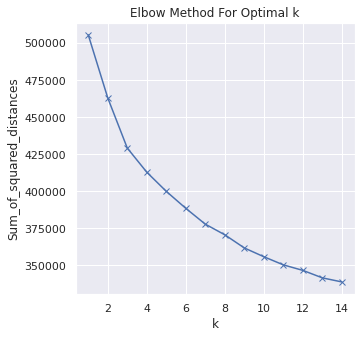

In [51]:
# Plot elbow graph. 

plt.figure(figsize=(5,5))

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow graph doesn't suggest a clear candidate for k.

In [0]:
# Create a function to show bin counts and silhouette scores for various k values. 

def cluster_eval(x, n):
    print("\n ------{} Clusters------ \n".format(n))
   
    km = KMeans(n_clusters=n, random_state=13).fit_predict(x)
    print("K-Means Bin Count: {}".format(np.bincount(km)))
    print("K-Means Silhouette Score: {}".format(metrics.silhouette_score(x, km, metric='euclidean')))

    gmm = GaussianMixture(n_components=n, random_state=13).fit_predict(x)
    print("GMM Bin Count: {}".format(np.bincount(gmm)))
    print("GMM Silhouette Score for: {}".format(metrics.silhouette_score(x, gmm, metric='euclidean')))
    

In [53]:
# Check k values from 2 to 10. 

for i in range(2,10):
    cluster_eval(unsup_df_dm, i)


 ------2 Clusters------ 

K-Means Bin Count: [101250  47582]
K-Means Silhouette Score: 0.08344500117867655
GMM Bin Count: [86710 62122]
GMM Silhouette Score for: 0.05652151665571769

 ------3 Clusters------ 

K-Means Bin Count: [54892 46358 47582]
K-Means Silhouette Score: 0.1046640382453478
GMM Bin Count: [40669 63165 44998]
GMM Silhouette Score for: 0.08922881220365521

 ------4 Clusters------ 

K-Means Bin Count: [40669 33268 35232 39663]
K-Means Silhouette Score: 0.09437329565694164
GMM Bin Count: [40669 33268 35232 39663]
GMM Silhouette Score for: 0.09437329565694164

 ------5 Clusters------ 

K-Means Bin Count: [40669 26768 22583 25544 33268]
K-Means Silhouette Score: 0.0798114486081936
GMM Bin Count: [40669 26768 22583 25544 33268]
GMM Silhouette Score for: 0.0798114486081936

 ------6 Clusters------ 

K-Means Bin Count: [23298 26768 33268 25106 27302 13090]
K-Means Silhouette Score: 0.08283891353874931
GMM Bin Count: [26546 24865 31844 24089 29315 12173]
GMM Silhouette Score f

#### Elbow Method & Silhouette Score Summary

Silhouette scores suggest that there are no clear K-means or GMM clusters with k in the range of 2-10. For the sake of investigation I will still look into the best performer with k=3.

In [0]:
# Based on the elbow graph and silhouette scores, three clusters look like the best k-value. 

km = KMeans(n_clusters=3, random_state=13).fit_predict(unsup_df_dm)

# add cluster label to dataset

tmp = pd.DataFrame(km)
unsup_df_dm['K-Means 3-Cluster'] = tmp.values

### K-Means Plots

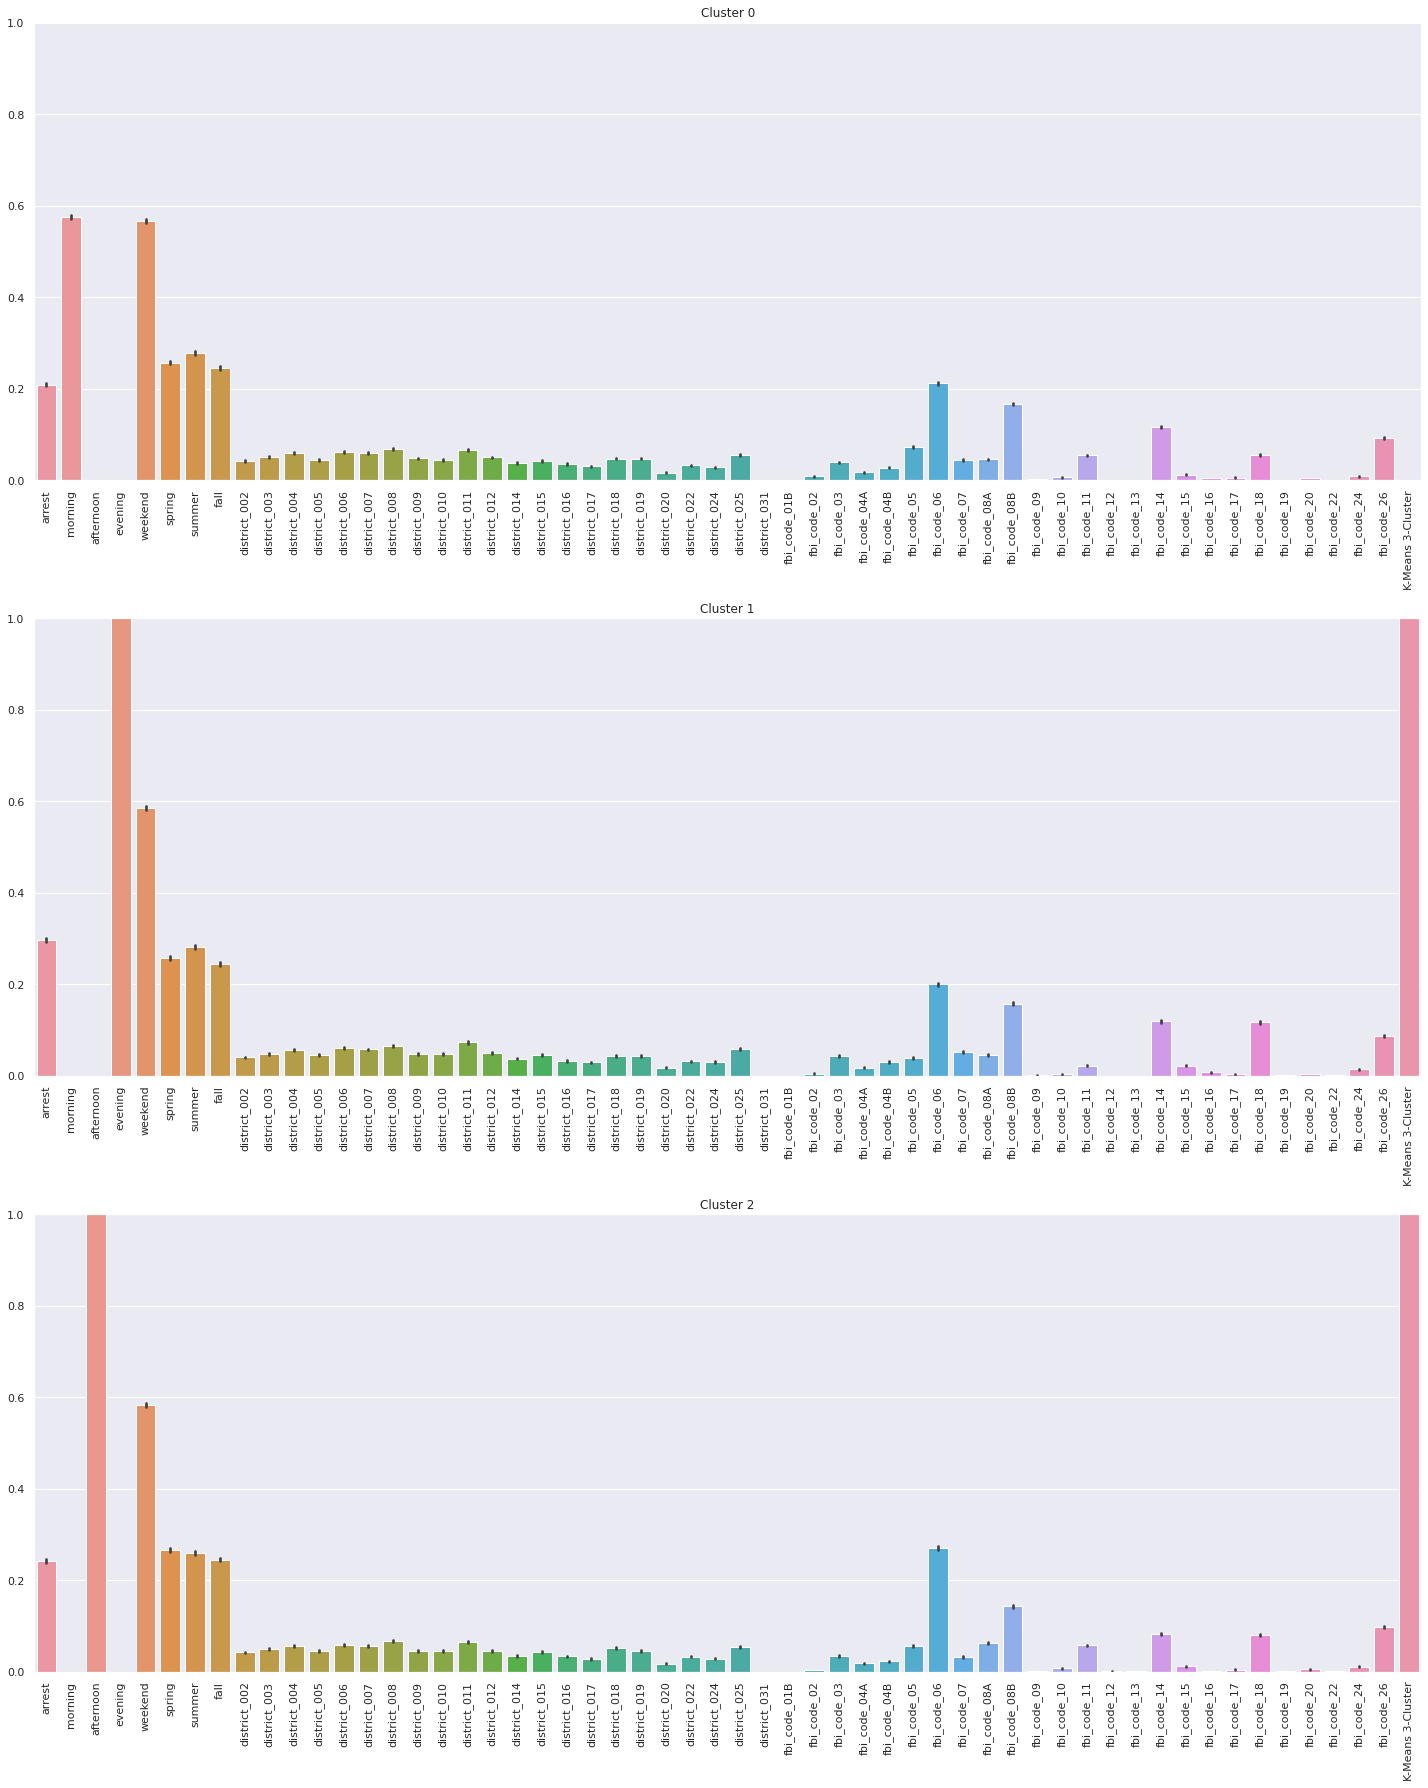

In [55]:
plt.figure(figsize=(20,25))

for i in range(0,3):
  plt.subplot(3, 1, i+1)
  sns.barplot(data = unsup_df_dm[unsup_df_dm['K-Means 3-Cluster'] == i])
  plt.title("Cluster {}".format(i))
  plt.xticks(rotation='vertical')
  plt.ylim(0, 1)

plt.tight_layout()
plt.show()

#### K-Means Plot Summary

These clusters don't provide much insight other than to show that the crime profile is similar throughout the day.

##Supervised Learning Feature Selection/Engineering

Given that all of the data in a police report is categorical, I set out in this section to determine which features are safest and most effective to use.

In [0]:
# I want to investigate geographic and crime type features that might be highly correlated. If they are then I will drop them from 
# the Spark dataframe when running my models.

feature_cols = ['beat', 'community_area', 'district', 'fbi_code', 'iucr', 'ward']

features_df = s_df_pandas[feature_cols]
features_df = features_df.astype('category')
features_dm_df = pd.get_dummies(features_df, drop_first=True)

# features_dm_df.head()

### Feature Correlation

In [57]:
# Find correlated features:

features_corrmat = features_dm_df.corr().abs()

# Select upper triangle of correlation matrix
upper = features_corrmat.where(np.triu(np.ones(features_corrmat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

to_drop

['community_area_52',
 'community_area_54',
 'community_area_74',
 'district_018',
 'iucr_0142',
 'iucr_0560',
 'iucr_0910',
 'iucr_1140',
 'iucr_1200',
 'iucr_1661']

#### Feature Correlation Summary

The results above tell me is that it is safe to use beat as a geographic feature and fbi code as the type of crime feature. Beat surpised me since it is the most localized geographic area and I assumed it would be correlated with districts or wards. I will also use ward and district as well since they appear to be safe to use as well. 

# Supervised Learning

The goal of this project is to produce a real-time predictive model based on millions of previous observations. To do this I utilize Spark 2.4.5's suite of classifiers.

In [0]:
# df.show()

In [0]:
# Create a subset dataframe that only includes uncorrelated columns

drp = ['community_area', 'date', 'description', 'iucr', 'latitude', 'location_description', 'longitude', 'primary_type']

s_df = df.drop(*drp)
# s_df.show()

## Spark Schema Cleaning

My pipeline utilizes StringIndexer and so each of my variables needs to be turned into type String.

In [60]:
s_df.printSchema()

root
 |-- arrest: boolean (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



In [0]:
# Need to recast columns as strings so that I can use StringIndexer to turn them into a numerical index.

s_df = s_df.withColumn("arrest", df['arrest'].cast('int')) # turn boolean into numerical
s_df = s_df.withColumn("arrest", s_df['arrest'].cast('string')) # numerical into string
s_df = s_df.withColumn("domestic", df['domestic'].cast('int'))
s_df = s_df.withColumn("domestic", s_df['domestic'].cast('string'))
s_df = s_df.withColumn("month", s_df['month'].cast('string'))
s_df = s_df.withColumn("hour", s_df['hour'].cast('string'))
s_df = s_df.withColumn("dayofweek", s_df['dayofweek'].cast('string'))
# s_df.show()

## Pipeline Construction

The pipeline is where my categorical variables get turned into dummies and then put into Spark's machine learning format of feature vectors and labels.

In [0]:
# Build a pipeline to get data ready for classifiers.

cols = s_df.columns

categoricalColumns = ['beat', 'district', 'domestic', 'fbi_code', 'ward', 'year', 'month', 'hour', 'dayofweek']
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                     outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'arrest', outputCol = 'label')
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [63]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(s_df)
s_df = pipelineModel.transform(s_df)
s_df.printSchema()

root
 |-- arrest: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- beatIndex: double (nullable = false)
 |-- beatclassVec: vector (nullable = true)
 |-- districtIndex: double (nullable = false)
 |-- districtclassVec: vector (nullable = true)
 |-- domesticIndex: double (nullable = false)
 |-- domesticclassVec: vector (nullable = true)
 |-- fbi_codeIndex: double (nullable = false)
 |-- fbi_codeclassVec: vector (nullable = true)
 |-- wardIndex: double (nullable = false)
 |-- wardclassVec: vector (nullable = true)
 |-- yearIndex: double (nullable = false)
 |-- yearclassVec: vector (nullable = true)
 |-- monthIndex: double (nullable = false)
 |-- monthclassVec: vector (null

In [0]:
# s_df.show()

## Split Data into Training and Test Sets

In [0]:
train_df, test_df = s_df.randomSplit([0.8, 0.2])

## Class Balancing via Weights

Since only 24.5% of the police reports result in an arrest I need to balance the dataset. I accomplish this by weighting the arrests 3x the weight of non-arrests.

In [66]:
dataset_size=float(train_df.select("arrest").count())
numArrests=train_df.select("arrest").where('arrest == 1').count()
per_arrest=(float(numArrests)/float(dataset_size))*100
numNonArrests=float(dataset_size-numArrests)
print('The number of arrests is {}'.format(numArrests))
print('Percentage of arrests from all reports is {}'.format(per_arrest))

The number of arrests is 588515
Percentage of arrests from all reports is 24.74366677079624


In [67]:
BalancingRatio= numNonArrests/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7525633322920376


In [0]:
train_df=train_df.withColumn("classWeights", when(train_df.arrest == 1,BalancingRatio).otherwise(1-BalancingRatio))
# train_df.select("classWeights").show(5)

## Logistic Regression

In [0]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', weightCol="classWeights", maxIter=10)
lrModel = lr.fit(train_df)

In [0]:
lr_predictions = lrModel.transform(test_df)

In [71]:
trainingSummary = lrModel.summary
print("Labels: {}".format(trainingSummary.labels))
print("Precision by label: {}".format(trainingSummary.precisionByLabel))
print("Recall by label: {}".format(trainingSummary.recallByLabel))

Labels: [0.0, 1.0]
Precision by label: [0.8836046450934866, 0.5792769137547971]
Recall by label: [0.8417325350907185, 0.662766454550861]


In [0]:
lr_selected = lr_predictions.select("label", "prediction", "probability")
# lr_selected.show()

In [0]:
lr_cm = lr_predictions.select("label", "prediction")

In [74]:
lr_cm.groupby('label').agg({'label': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|  0.0|      447557|
|  1.0|      146860|
+-----+------------+



In [75]:
lr_cm.groupby('prediction').agg({'prediction': 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|           425671|
|       1.0|           168746|
+----------+-----------------+



In [76]:
TP = lr_cm.filter(("label = 1 and prediction = 1")).count()
TP

97331

In [77]:
FP = lr_cm.filter(("label = 0 and prediction = 1")).count()
FP

71415

In [78]:
FN = lr_cm.filter(("label = 1 and prediction = 0")).count()
FN

49529

In [79]:
TN = lr_cm.filter(("label = 0 and prediction = 0")).count()
TN

376142

In [80]:
print("Precision: " + str(TP/(TP+FP)))
print("Sensitivity or Recall: " + str(TP/(TP+FN)))

Precision: 0.5767899683548054
Sensitivity or Recall: 0.6627468337191883


In [81]:
lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print(lr_evaluator.evaluate(lr_predictions))
print(lr_evaluator.getMetricName())

0.8384947210381714
areaUnderROC


### ROC Plot

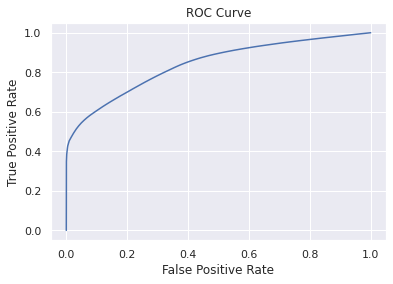

Training set areaUnderROC: 0.8393476777697827


In [82]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### PR Plot

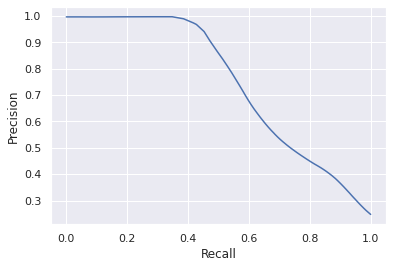

In [83]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Random Forest

In [0]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df)
rf_predictions = rfModel.transform(test_df)
# rf_predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

In [85]:
rf_evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8056898559430996


## Gradient Boosted Tree

In [0]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_df)
gbt_predictions = gbtModel.transform(test_df)

In [87]:
gbt_evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8261035308939508


## Base Model Summary

Logistic Regression has the best ROCAUC so I'll be optimizing the LR model. The threshold on this model can be customized to improve Precision or Recall depending on industry knowledge and needs.

# Model Optimization

In [0]:
paramGrid = (ParamGridBuilder()
    .addGrid(lr.aggregationDepth, [2,5,10])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.fitIntercept, [False, True])
    .addGrid(lr.maxIter, [10, 100, 1000])
    .addGrid(lr.regParam, [0.01, 0.5, 2.0]) 
    .build())

In [0]:
# # Create 3-fold CrossValidator

# cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=3)

# cvModel = cv.fit(train_df)

# predict_test=cvModel.transform(test_df)
# print("The area under ROC for test set after CV  is {}".format(lr_evaluator.evaluate(predict_test)))

## Model Optimization Summary 

Very minimal improvement from tweaking testing parameters.

# Prediction Function

Create a function to produce a prediction for a new data point simulating real-time prediction.

In [0]:
# Set parameters for a new Chicago Data Portal API query (simulates a new data entry)

main_api ='https://data.cityofchicago.org/resource/crimes.json'
limit = 1
offset = 0
path = '/content/gdrive/My Drive/Colab Datasets/final_project_files/'
filename = 'new_data_'
filenum = 1

# Call the City Data Portal for crime data and store results in files on gdrive. This is to simulate getting the prediction for a new report.
while offset < 1:
  response = requests.get(main_api + '?' + '$limit=' + str(limit) + '&' + '$offset=' + str(offset))
  data = response.json()
  with open(path + filename + str(filenum) + '.json', 'w') as f: 
    json.dump(data, f)
  offset += limit
  filenum += 1

new_data = spark.read.json(path + 'new_data_1.json')

In [0]:
def probability_of_arrest(new_data):
  import pyspark.sql.functions as F
  from pyspark.sql.types import FloatType

  new_data = new_data.drop(*columns_to_drop)
  new_data = new_data.withColumn("date", to_timestamp("date"))
  new_data = new_data.withColumn("month", month("date"))
  new_data = new_data.withColumn("hour", hour("date"))
  new_data = new_data.withColumn("dayofweek", dayofweek("date"))
  new_data = new_data.drop(*drp)
  new_data = new_data.withColumn("arrest", new_data['arrest'].cast('int')) # turn boolean into numerical
  new_data = new_data.withColumn("arrest", new_data['arrest'].cast('string')) # numerical into string
  new_data = new_data.withColumn("domestic", new_data['domestic'].cast('int'))
  new_data = new_data.withColumn("domestic", new_data['domestic'].cast('string'))
  new_data = new_data.withColumn("month", new_data['month'].cast('string'))
  new_data = new_data.withColumn("hour", new_data['hour'].cast('string'))
  new_data = new_data.withColumn("dayofweek", new_data['dayofweek'].cast('string'))

  new_data = pipelineModel.transform(new_data)

  new_pred = lrModel.transform(new_data)
  new_pred = new_pred.select("prediction", "probability")
  udf1 = F.udf(lambda x : 1 - float(x[0]),FloatType())
  new_pred.select('prediction',udf1('probability').alias('probability of arrest')).show()

In [93]:
probability_of_arrest(new_data)

+----------+---------------------+
|prediction|probability of arrest|
+----------+---------------------+
|       0.0|           0.20856921|
+----------+---------------------+



# Conclusion

This project set out and accomplished three things:
1. Gain insight into the crime profile of Chicago through visualizations and mapping.
2. Enable community leaders to scrutinize current police behavior and outcomes.
3. Create a customizable real-time predictor of arrest liklihood for dispatchers that could be of value to them when deciding on the level of police resource allocation.

What is evident thought this analysis is that there are definite patterns in what type, when, and where crimes are committed and whether those reports will lead to arrests. This project though is not a crime predictor but rather a summary of police behavior and outcomes. While dispatchers might find it helpful to know what has happened in the past so that they can be more effective and efficient, I also hope that Police Administrators might use this tool to accomplish a fourth objective: analyzing past police behavior and outcomes and in conjunction with community leaders, change current practices so that police resources are used more effectively, efficiciently and equitably to ensure public safety and law enforcement throughout the city, not just in particular pockets and for particular communities.

To this end, additional analysis could be conducted that brings in information such as district: demographics, SES, employment, school performance and non-profit acitivity. Everyone wants to ensure a safe and thriving community, but the means of achieving that can be different and better serve the people by understanding and learning from the past. 